In [2]:
import scipy.integrate as integrate 
import math
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.integrate as integrate 
import cmath 
from scipy import optimize
from scipy.misc import derivative

In [3]:
#yukawa coupling constant of fermion f 
y_f = 0.99                                          #(for the top quark)

#EW - sector coupling constants g (SU(2)_L) and g_p (U(1)_Y) 
g = 0.65
g_p = 0.36
eps = 0.0000001

# Effective mass of fermion f acquired through yukawa coupling w/ the Higgs
def m_f(phi):
    return y_f**2/2*phi**2 + eps

# W and Z boson masses
def m_W(phi):
    return (g**2/4)*phi**2 + eps

def m_Z(phi):
    return (g**2 + g_p**2)*phi**2/4 + eps

# Higgs and Goldstone masses
def m_h(phi):                                               
    return -3*lam*phi**2 - mu + (15/4)*phi**4/Lam**2 + eps

#m_h 0 at h_min = (2/5)*(lam/c6)*(1 - np.sqrt(1-5/3*c6*(mu**2)/lam**2))

def m_g(phi):
    return -lam*phi**2 - mu + (3/4)*phi**4/Lam**2 + eps


In [4]:
# different parts of the 1-loop effective potential calculated in the ms-scheme.
# separating the contribution coming from gauge bosons and other particles in the loop correction. 
# obs! input for the first order corrections are the squared masses, i.e. m**2 and not m.  

def v_tree(phi):
    return -mu/2*phi**2 - lam/4*phi**4 + 1/(8*Lam**2)*phi**6

def v_loop_g(m):
    #Coleman-Weinberg potential for gauge bosons as a function of mass squared.
    scale = 246
    return m**2/(64*np.pi**2)*(cmath.log(m/scale) - 5/6)

def v_loop(m):
    #Coleman-Weinberg potential for particles as a function of mass squared.
    scale = 246
    return m**2/(64*np.pi**2)*(cmath.log(m/scale) - 3/2)


def v_1(phi):
    return np.real(v_loop(m_h(phi)) + 3*v_loop(m_g(phi)) - 12*v_loop(m_f(phi))
             + 3*v_loop_g(m_Z(phi)) + 6*v_loop_g(m_W(phi)))

#this is the temperature independent part of the effective potential
def v_eff_0(phi):
    return np.real(v_tree(phi) + v_1(phi))


#defining high T expansion of the bosonic (j_b) and fermionic (j_f) thermal functions
def j_b(y):
    a_b = np.pi**2*np.exp(3/2 - 2*0.5572)
    return (np.pi**2/12)*y**2 - np.pi/6*y**3 - (1/32)*y**4*cmath.log(y**2/a_b)

def j_f(y):
    a_f = 16*np.pi**2*np.exp(3/2 - 2*0.5572)
    return -(np.pi**2/24)*y**2 - (1/32)*y**4*cmath.log(y**2/a_f)

def v_eff_T(phi,T):
    return T**4/(2*np.pi**2)*(j_b(cmath.sqrt(m_h(phi))/T) + 3*j_b(cmath.sqrt(m_g(phi))/T) + 3*j_b(cmath.sqrt(m_Z(phi))/T)
                             + 6*j_b(cmath.sqrt(m_W(phi))/T) - 12*j_f(cmath.sqrt(m_f(phi))/T))

24.31949317715978


Text(0.5, 1.0, '1-loop effective potential at  T = 88.1691 GeV')

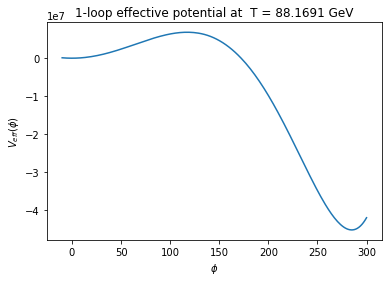

In [73]:
mu = 181.11189133118546
lam = 0.05224133191889968
Lam = 634.4481474884878


#1-loop effective potential
def v_eff(phi,T):
    return np.real(v_eff_0(phi) + v_eff_T(phi,T)) - np.real(v_eff_0(0) + v_eff_T(0,T)) 
    
a = -6*lam + 9/4*g**2 + 3/4*g_p**2 + 3*y_f**2
phi = np.linspace(-10, 300, 200)

T_min = np.sqrt(12/a)*np.sqrt(mu) 
print(T_min)
T = 88.16910740065379

plt.plot(phi, np.vectorize(v_eff)(phi,T))
plt.xlabel('$\phi$')
plt.ylabel('$V_{eff}(\phi)$')
plt.title('1-loop effective potential at  T = %1.4f GeV'  % T)

In [131]:
#Finding the critical temperature where the effective potential acquires the same value at both minima


# defining a recursive method for finding the critical temperature up to some tolerance which is chosen when calling the 
# function. The function requires a span/interval of temperaturs to as to where it should look for the 
#
# 


def find_t_crit(t_span, tolerance):
    T = np.mean(t_span)
    
    def v_eff_T(phi):
        return v_eff(phi,T)
    
    symm_vac = optimize.fmin(v_eff_T, 0, disp = 0)[0]
    broken_vac = optimize.fmin(v_eff_T, 300, disp = 0)[0]
    
    
    min1 = v_eff_T(symm_vac)
    min2 = v_eff_T(broken_vac)
    
    if np.abs(symm_vac - broken_vac) <= tolerance:
        #this is condition for T being too high and only in symmetric phase, Tis to high
        return find_t_crit([t_span[0], np.mean(t_span)], tolerance)
    
    elif np.abs(min2 - min1) <= tolerance:
        #condition for being at the critical temperature
        return T, broken_vac
    
    elif min2 - min1 > tolerance:
        #the broken phase is higher up than the symmetric one, Temperature is to high
        return find_t_crit([t_span[0], np.mean(t_span)],tolerance)
    else:
        return find_t_crit([np.mean(t_span), t_span[1]],tolerance) 

    
t_span = [1.01*T_min, 300]
tolerance = 1

t_c , phi_c = find_t_crit(t_span, tolerance)   
print(t_c, phi_c)
print('strength of phase transition:', phi_c/t_c)

122.26879014110753 251.748046875
strength of phase transition: 2.058972257633886


In [74]:
# Finding the bounce action at some nucleation temperature: later tn chosen s.t s3/tn ~ 140.  
tn = T

def v_eff_tn(phi):
    return np.vectorize(v_eff)(phi,tn)


#derivative of v_eff at nucleation temperature
def dv_eff(phi):
    #a = 6*lam + 9/4*g**2 + 3/4*g_p**2 + 3*y_f**2
    #b = 3/8*(g**2 + g_p**2)**(3/2) + 6/8*g**3
    #c = lam/4*(1 + c6/lam*tn**2)
    
    return derivative(v_eff_tn, phi, dx = 0.00001, order=7)

def f(t,y):  
    A = y[0]
    B = y[1]
    
    dA_dt = B
    dB_dt = dv_eff(A) - (2/t)*B                               
    return np.array([dA_dt, dB_dt])


284.94598388671875
0
[-2  2] 

The solver successfully reached the end of the integration interval.
iteration:  1
y0 =  142.47299194335938
undershoot
smallest value of the solution: 112.00757133099297
And it ended at 117.68585680318516


The solver successfully reached the end of the integration interval.
iteration:  2
y0 =  213.70948791503906
undershoot
smallest value of the solution: 94.78832872604491
And it ended at 118.68021778852295


The solver successfully reached the end of the integration interval.
iteration:  3
y0 =  249.3277359008789
undershoot
smallest value of the solution: 81.27780201096603
And it ended at 119.68878406839659


The solver successfully reached the end of the integration interval.
iteration:  4
y0 =  267.1368598937988
undershoot
smallest value of the solution: 70.31409061008279
And it ended at 120.45907822394788


The solver successfully reached the end of the integration interval.
iteration:  5
y0 =  276.0414218902588
undershoot
smallest value of the soluti

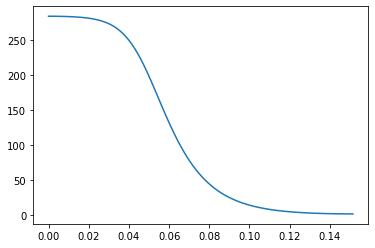

In [76]:
# Overshoot-undershoot implementation to find the bounce solution. Works in the same way as finding the critical temp
# algorithm get's stuck somtetimes due to np.mean not being sensitive enough(?).

symm_vac = 0

broken_vac = optimize.fmin(v_eff_tn, 300, disp = 0)[0]
tol = 2

print(broken_vac)
print(symm_vac)
print(np.array([symm_vac - tol, symm_vac + tol]), '\n')

def over_undershoot(init_span, tol, max_i, iter = None):
    
    if iter is None:
        iter = 0
        
    iter +=1    
    
    if iter == max_i:
        print('arrived at max iterations')
        print('final span: ', init_span)
        
    else:
        t_span = np.array([eps, 1])
        times  = np.linspace(t_span[0], t_span[1], 100) 
        init = np.mean(init_span)
        y0 = np.array([init, 0])
    
        soln = solve_ivp(f, t_span, y0, t_eval = times)
        print(soln.message)   
    
    
        t = soln.t
        phi_b = soln.y[0] 
    
    
        if np.abs(np.min(phi_b) - symm_vac) <= tol or np.abs(phi_b[-1] - symm_vac) <= tol: 
            # Here we have the bounce solution. r_max is the bubble radius, smallest value of the solution which satisfies
            # the bounce condition. We run the solver again for the span 0 - r_max and that will be what is returned. 
            index_r = np.where(np.abs(phi_b - symm_vac) <= tol)
            r_max = t[np.min(index_r)]
            
            t_span = np.array([eps, r_max])
            times  = np.linspace(t_span[0], t_span[1], 100) 
            y0 = np.array([init, 0])
    
            soln = solve_ivp(f, t_span, y0, t_eval = times)
            
            r = soln.t
            phi_b = soln.y[0] 
            
            print('Found it! y0=', init)
            return phi_b, r, soln.y[1], init, r_max
    
        elif phi_b[-1] < symm_vac - tol or phi_b[-1] > broken_vac:
            #condition for rolling down to the left towards phi = -inf &
            #condition for rolling down to the right towards phi = +inf or other local well 
            #This means we are too far high up in the span and initial condition is to high.
        
            print('iteration: ', iter)
            print('y0 = ', init)
            print('overshoot')
            print('final value of the solution:', phi_b[-1])
            print('\n')
            return over_undershoot([init_span[0], init], tol, max_i, iter)
    
        else:  #phi_b[-1] > symm_vac + tol and phi_b[-1] < init:
            # All other scenarios are undershoot.
            # The initial value is to low need to look higher up in the interval for the correct initial value
            
            print('iteration: ', iter)
            print('y0 = ',  init)
            print('undershoot')
            print('smallest value of the solution:' , np.min(phi_b))
            print('And it ended at', phi_b[-1])
            print('\n')
            return over_undershoot([init, init_span[1]],tol, max_i, iter)
                
              
init_span = np.array([symm_vac, broken_vac])     
                                                      
phi_b, r, phi_dot, ic, r_max = over_undershoot(init_span, tol, 100)


plt.plot(r, phi_b)
print(ic)

In [77]:
#Effective potential values of phi = bounce.  
v_bounce = np.vectorize(v_eff)(phi_b,tn)

#R is the interval over which we want to integrate the functional over to get the bounce action.
#L is the euclidean lagrangian density to be integrated.  

R = np.linspace(0, r_max, len(phi_b))
L = ((1/2)*(phi_dot)**2 + v_bounce)

s3 = 4*np.pi*np.trapz((R**2)*L, R)


print('Bounce action over temperature s3/tn = ', s3/tn)

Bounce action over temperature s3/tn =  203.69207288894853


In [71]:
## Calculating the latent heat

g_star = 106.95
rho_rad = np.pi**2*g_star*(tn**4)/30
delta_v = v_eff(symm_vac, tn) - v_eff(broken_vac,tn)
delta_dv = dv_eff(symm_vac) - dv_eff(broken_vac)

alpha = (1/rho_rad)*(delta_v - (1/4)*delta_dv)

print(rho_rad)
print(delta_v)
print(delta_dv)
print(alpha)

3139569358.8231134
33520068.851032425
-0.4540430381894111
0.010676645467424356


In [72]:
#Calculating the invers nucleation time
#First up is defining the derivative of the  

def dv_dT(phi,T):
    # Fourth order finite difference scheme for approximation of derivative off effective action along T
    h = 1.4901161193847656e-8
    
    return np.real(-v_eff(phi, T + 2*h) + 8*v_eff(phi, T + h) - 8*v_eff(phi,T - h)
                  + v_eff(phi, T - 2*h))/(12*h)



dv = np.vectorize(dv_dT)(phi_b,tn)

ds3_dT = 4*np.pi*np.trapz(R**2*dv, R)

print(ds3_dT)
beta = ds3_dT - s3/tn
print(beta)

2403.644848235524
2172.4764059335985


In [138]:
print('alpha = ', alpha)
print('beta over H =', beta)
print('nucelation temperature', tn)

alpha =  0.006224796701073189
beta over H = 953.5466483155474
nucelation temperature 110
